# TORCH.AUTOGRAD 를 사용한 자동 미분
신경망을 학습할 때 가장 자주 사용되는 알고리즘은 **역전파**입니다. 이 알고리즘에서, 매개변수는 주어진 매개변수에 대한 손실 함수의 gradient에 따라 조정됩니다.

이러한 gradient를 계산하기 위해 PyTorch에는 torch.autograd 라고 불리는 자동 미분 엔진이 내장되어 있습니다. 이는 모든 계산 그래프에 대한 gradient의 자동 계산을 지원합니다.

입력 x, 매개변수 w와 b, 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층 신경망을 가정하겠습니다.

In [2]:
import torch

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad = True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x,w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

# Tensor, Function과 연산 그래프
이 코드는 다음의 연산 그래프를 정의합니다:
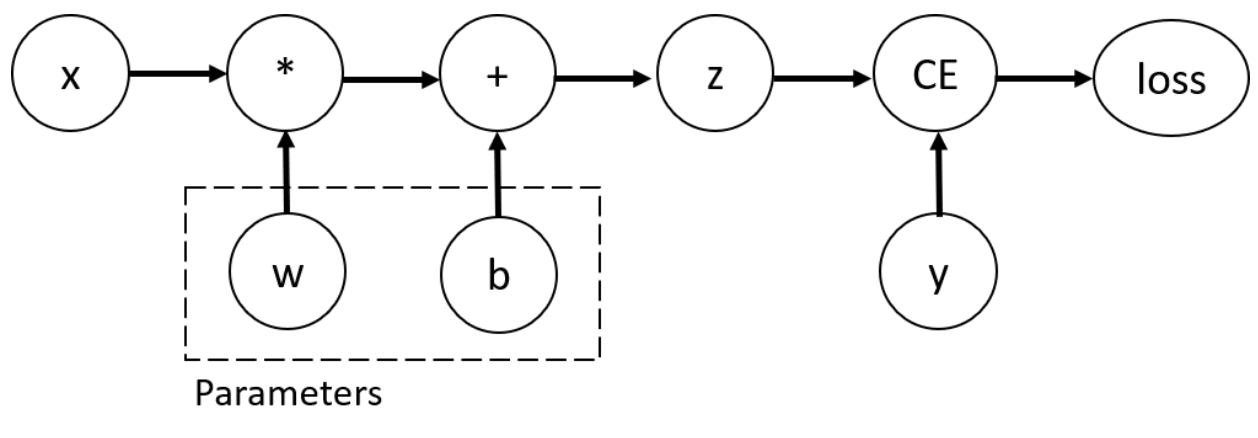
이 신경망에서 w와 b는 최적화해야하는 매개변수 입니다. 따라서 이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 합니다. 이를 위해서 해당 텐서에 requires_grad 속성을 설정합니다.

연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 Function 클래스의 객체 입니다. 이 객체는 forward 방향으로 함수를 계산하는 방법과, 역방향 전파 단계에서 도함수를 계산하는 방법을 알고 있습니다. 역방향 전파 함수에 대한 참조는 텐서의 grad_fn 속성에 저장됩니다.

In [3]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7a2993507d60>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7a2993507c40>


# Gradient 계산하기
신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수를 계산해야합니다.
즉 x와 y의 일부 고정값에서 w.grad와 b.grad가 필요합니다. 이러한 도함수를 계산하기 위해, loss.backward() 를 호출한 다음, w.grad와 b.grad에서 값을 가져옵니다:

In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0420, 0.2520, 0.1969],
        [0.0420, 0.2520, 0.1969],
        [0.0420, 0.2520, 0.1969],
        [0.0420, 0.2520, 0.1969],
        [0.0420, 0.2520, 0.1969]])
tensor([0.0420, 0.2520, 0.1969])


# 참고


*   연산 그래프의 leaf 노드들 중 requires_grad 속성이 True로 설정된 노드들의 grad 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가 유효하지 않습니다.
*   성능 상의 이유로, 주어진 그래프에서의 backward를 사용한 변화도 계산은 한 번만 수행할 수 있습니다. 만약 동일한 그래프에서 여러번의 backward 호출이 필요하면, backward 호출 시에 retain_graph=True 를 전달해야합니다.



# gradient 추적 멈추기
기본적으로, requires_grad = True인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을 지원합니다. 그러나 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우에는, 이러한 추적이나 지원이 필요 없을 수 있습니다. 연산 코드를 torch.no_grad() 블록으로 둘러싼 연산 추적을 멈출 수 있습니다.


In [5]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


# 연산 그래프에 대한 추가 정보
개념적으로, autograd는 데이터(tensor)의 및 실행된 모든 연산들의 기록을 Function 객체로 구성된 방향성 비순환 그래프에 저장됩니다. 이방향성 비순환 그래프의 잎은 입력 텐서이고, 뿌리는 결과 텐서 입니다. 이 그래프를 뿌리에서부터 잎까지 추적하면 연쇄 법칙에 따라 변화도를 자동으로 계산할 수 있습니다.

순전파 단계에서,autograd는 다음 두 가지 작업을 동시에 수행합니다:


*   요청된 연산을 수행하여 결과 텐서를 계산하고,
*   DAG에 연산의 gradient function을 유지합니다.

역전파 단계는 DAG 뿌리에서 .backward()가 호출될 때 시작됩니다. autograd는 이 때:


*    각 .gard_fn으로 부터 gradient를 계산하고,
*    각 텐서의 .grad 속성에 계산 결과를 쌓고
*    연쇄 법칙을 사용하여, 모든 잎 텐서들까지 전파합니다.




In [6]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])
